In [24]:
import os
import xarray as xr
import pandas as pd
import geopandas as gpd
import numpy as np
import shapely
#import cftime
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import contextily as cx
import re

from pathlib import Path
import pathlib

In [25]:
country = 'TJK'

In [33]:
damage_data_path = Path(pathlib.Path.home().parts[0]) / 'Projects' / 'gmhcira' / 'data' / 'damage' / country
eq_damage_data_path = damage_data_path / 'earthquake' #with liquefaction
#eq_damage_data_path = damage_data_path / 'earthquake_results_adb_liq' #with liquefaction
#eq_damage_data_path = damage_data_path / 'earthquake_adb_gar_overlay' #without liquefaction

admin_path = Path('C:\\Users\snn490\OneDrive - Vrije Universiteit Amsterdam\ADB\Data\exposure')
figures_path = Path('C:\\Users\snn490\OneDrive - Vrije Universiteit Amsterdam\ADB\Figures\Earthquakes')

In [31]:
eq_damage_data_path

WindowsPath('C:/Projects/gmhcira/data/damage/TJK')

In [27]:
subnational = gpd.read_file(admin_path / 'gadm41_TJK.gpkg',layer=3)
subnational = subnational.to_crs(3857)

In [28]:
def calculate_risk(road_segment, damages_dict):
    damages_lst = [damages_dict[rp][damages_dict[rp]['osm_id'] == road_segment]['Partial destruction (0.5)'].iloc[0] for rp in [*damages_dict]]
    asset_dam_df = pd.DataFrame([1/rp for rp in [*damages_dict]]+[1,1e-10],damages_lst+[0, max(damages_lst)]).reset_index()
    asset_dam_df.columns = ['damage','prob']
    asset_dam_df = asset_dam_df.sort_values('prob',ascending=True).reset_index(drop=True)
    return np.trapz(asset_dam_df.damage.values,asset_dam_df.prob.values) #np.trapz(y,x)

def calculate_risk_vectorized(row):
    damages_lst = row.values
    rps = row.index
    if isinstance((row.index)[0], str): rps = [int(s) for con_rp in rps for s in re.findall(r'\d+', con_rp)]
    prob_values = np.array([1/rp for rp in rps] + [1, 1e-10]) # no design standard for earthquakes
    damage_values = np.append(damages_lst, [0, max(damages_lst)])
    sorted_indices = np.argsort(prob_values)
    prob_values = prob_values[sorted_indices]
    damage_values = damage_values[sorted_indices]
    return np.trapz(damage_values, prob_values)

def get_province(road_segment,subnational):
    try:
        column_names = subnational.columns
        if 'GID_3' in column_names:
            return subnational.loc[road_segment.geometry.intersects(subnational.geometry)].GID_3.values[0]
        elif 'GID_2' in column_names:
            return subnational.loc[road_segment.geometry.intersects(subnational.geometry)].GID_2.values[0]
    except:
        return None

def calculate_damage(road_segment):
    if road_segment.asset in ['primary','trunk','trunk_link','primary_link', 'motorway', 'motorway_link']:
        return road_segment["E7.12"]*0.18+road_segment["E7.7"]*0.39+road_segment["E7.11"]*0.43
    elif road_segment.asset in ['secondary','secondary_link']:
        return road_segment["E7.12"]*0.10+road_segment["E7.7"]*0.31+road_segment["E7.11"]*0.59
    elif road_segment.asset in ['tertiary','tertiary_link','road','residential','unclassified', 'track']:
        return road_segment["E7.12"]*0.09+road_segment["E7.7"]*0.25+road_segment["E7.11"]*0.66

# Calculate EAD per curve

In [34]:
# read parquets per return period
haz_rp_lst = [250, 475, 975, 1500, 2475]
road_types_lst = ['unclassified', 'primary', 'secondary', 'tertiary', 'residential', 
                                'trunk', 'trunk_link',  'motorway','motorway_link',  'primary_link','secondary_link', 'tertiary_link','road', 'track' ]
road_types_lst_remove = []
assump_curves = ['E7.1', 'E7.6', 'E7.7', 'E7.8', 'E7.9', 'E7.10', 'E7.11', 'E7.12', 'E7.13', 'E7.14' ]
#create df with all unique ID numbers, geometry and column ead
ead_df = gpd.GeoDataFrame(columns=['osm_id', 'asset', 'geometry']+['ead_{}'.format(curve_id) for curve_id in assump_curves] 
                          +['ead_{}_overlay'.format(rp_trig) for rp_trig in haz_rp_lst], geometry='geometry')


for road_type in road_types_lst:
    #create damages_dictionary containing damages for different return periods for asset type
    damages_dict = {key: pd.DataFrame() for key in haz_rp_lst}
    for rp in haz_rp_lst:
        damage_data_path_list = eq_damage_data_path.iterdir()                    
        data_path = [path for path in damage_data_path_list if '_{}y_road_{}'.format(rp,road_type) in str(path)]
        if len(data_path) != 0:
            df = gpd.read_parquet(data_path[0])
            damages_dict[rp] = pd.concat([damages_dict[rp], df], ignore_index=True)  #create dictionary with the return period 
            for curve_id in assump_curves: damages_dict[rp] = damages_dict[rp].rename(columns={curve_id: f"{curve_id}_{rp}"}) # Rename the curve_id column in the damages_dict[rp] DataFrame
        else:
            print('No data for {}'.format(road_type))
            road_types_lst_remove.append(road_type)

    if road_type not in road_types_lst_remove:
        #calculate EAD
        osm_id_columns = [df['osm_id'] for df in damages_dict.values()] # Get all 'osm_id' columns from the DataFrames in damages_dict
        if all(df.equals(osm_id_columns[0]) for df in osm_id_columns): # Compare all 'osm_id' columns
            print("All osm_id columns are equal: True")
            temp_df = damages_dict[haz_rp_lst[0]][['osm_id', 'asset', 'geometry']]
            #temp_df = temp_df[0:2]
            print('These are the damages per return period for {}'.format(road_type))
            for curve_id in assump_curves:
                temp_df_curve = temp_df[['osm_id']]
                for rp in haz_rp_lst: #print(damages_dict[rp][['osm_id', f"{curve_id}_{rp}"]])
                    temp_df_curve = temp_df_curve.merge(damages_dict[rp][['osm_id', f"{curve_id}_{rp}"]], on='osm_id', how='left')
                temp_df_curve.set_index('osm_id', inplace=True)
                temp_df_curve.columns = temp_df_curve.columns.str.replace(f"{curve_id}_", '', regex=False)
                temp_df.loc[:, ['ead_{}'.format(curve_id)]] = temp_df.apply(lambda row: calculate_risk_vectorized(temp_df_curve.loc[row['osm_id']]) if row['osm_id'] in temp_df_curve.index else np.nan, axis=1)
                for rp in haz_rp_lst: print("The damage for a {} year return event following curve {}: {:,.2f}".format(rp, curve_id, temp_df_curve['{}'.format(rp)].sum()))
            ead_df = pd.concat([ead_df, temp_df], ignore_index=True)  #create dictionary with the return period 
        
        else:
            temp_df = pd.concat([damages_dict[rp][['osm_id', 'asset', 'geometry']] for rp in damages_dict.keys()]).drop_duplicates(subset=['osm_id']) #merge dataframes into one and remove duplicates based on id_number 
            print("osm_id columns are not equal")

ead_df = ead_df.to_crs(3857)

for curve_id in assump_curves:
    print('This is the EAD for earthquakes using curve {}: {:,}'.format(curve_id, ead_df['ead_{}'.format(curve_id)].sum()))
    #print('This is the max EAD for road segment using curve {}: {:,}'.format(curve_id, ead_df['ead_{}'.format(curve_id)].max()))

All osm_id columns are equal: True
These are the damages per return period for unclassified
The damage for a 250 year return event following curve E7.1: 569,288.95
The damage for a 475 year return event following curve E7.1: 4,658,095.85
The damage for a 975 year return event following curve E7.1: 12,258,950.51
The damage for a 1500 year return event following curve E7.1: 28,536,942.36
The damage for a 2475 year return event following curve E7.1: 69,631,771.62
The damage for a 250 year return event following curve E7.6: 750,716.36
The damage for a 475 year return event following curve E7.6: 5,491,075.69
The damage for a 975 year return event following curve E7.6: 12,360,724.50
The damage for a 1500 year return event following curve E7.6: 27,320,090.52
The damage for a 2475 year return event following curve E7.6: 64,405,488.52
The damage for a 250 year return event following curve E7.7: 714,102.69
The damage for a 475 year return event following curve E7.7: 5,374,335.18
The damage for a

C:\Users\snn490\AppData\Local\Temp\ipykernel_17064\2116331334.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ead_df = pd.concat([ead_df, temp_df], ignore_index=True)  #create dictionary with the return period


All osm_id columns are equal: True
These are the damages per return period for primary
The damage for a 250 year return event following curve E7.1: 796,004.40
The damage for a 475 year return event following curve E7.1: 4,235,544.49
The damage for a 975 year return event following curve E7.1: 21,024,934.23
The damage for a 1500 year return event following curve E7.1: 50,502,957.72
The damage for a 2475 year return event following curve E7.1: 104,437,458.02
The damage for a 250 year return event following curve E7.6: 1,037,288.03
The damage for a 475 year return event following curve E7.6: 5,048,287.21
The damage for a 975 year return event following curve E7.6: 20,574,585.21
The damage for a 1500 year return event following curve E7.6: 47,485,495.02
The damage for a 2475 year return event following curve E7.6: 95,459,444.86
The damage for a 250 year return event following curve E7.7: 989,777.43
The damage for a 475 year return event following curve E7.7: 4,927,355.57
The damage for a 9

# Calculate EAD considering road conditions based on curves

In [35]:
#calculate EAD for specific curve combinations
# read parquets per return period
haz_rp_lst = [250, 475, 975, 1500, 2475]
road_types_lst = ['unclassified', 'primary', 'secondary', 'tertiary', 'residential', 
                                'trunk', 'trunk_link',  'motorway','motorway_link',  'primary_link','secondary_link', 'tertiary_link','road', 'track' ]
road_types_lst_remove = []
assump_curves = ['E7.11','E7.7','E7.12']
#create df with all unique ID numbers, geometry and column ead
ead_df = gpd.GeoDataFrame(columns=['osm_id', 'asset', 'geometry']+['ead'] 
                          +['overlay_{}'.format(rp_trig) for rp_trig in haz_rp_lst], geometry='geometry')


for road_type in road_types_lst:
    #create damages_dictionary containing damages for different return periods for asset type
    damages_dict = {key: pd.DataFrame() for key in haz_rp_lst}
    for rp in haz_rp_lst:
        damage_data_path_list = eq_damage_data_path.iterdir()                    
        data_path = [path for path in damage_data_path_list if '_{}y_road_{}'.format(rp,road_type) in str(path)]
        if len(data_path) != 0:
            df = gpd.read_parquet(data_path[0])
            damages_dict[rp] = pd.concat([damages_dict[rp], df], ignore_index=True)  #create dictionary with the return period 
            #for curve_id in assump_curves: damages_dict[rp] = damages_dict[rp].rename(columns={curve_id: f"{curve_id}_{rp}"}) # Rename the curve_id column in the damages_dict[rp] DataFrame
        else:
            print('No data for {}'.format(road_type))
            road_types_lst_remove.append(road_type)

    if road_type not in road_types_lst_remove:
        #calculate EAD
        osm_id_columns = [df['osm_id'] for df in damages_dict.values()] # Get all 'osm_id' columns from the DataFrames in damages_dict
        if all(df.equals(osm_id_columns[0]) for df in osm_id_columns): # Compare all 'osm_id' columns
            print("All osm_id columns are equal: True")
            temp_df = damages_dict[haz_rp_lst[0]][['osm_id', 'asset', 'geometry']]
            #temp_df = temp_df[0:2]
            print('These are the damages per return period for {}'.format(road_type))
            temp_df_curve = temp_df[['osm_id']]
            for rp in haz_rp_lst: #print(damages_dict[rp][['osm_id', f"{curve_id}_{rp}"]])
                damages_dict[rp]['total_damage_{}'.format(rp)] = damages_dict[rp].apply(lambda x: calculate_damage(x),axis=1)
                temp_df_curve = temp_df_curve.merge(damages_dict[rp][['osm_id', f"total_damage_{rp}"]], on='osm_id', how='left')
            temp_df_curve.set_index('osm_id', inplace=True)
            #temp_df_curve.columns = temp_df_curve.columns.str.replace(f"total_damage_", '', regex=False)
            temp_df.loc[:, ['ead']] = temp_df.apply(lambda row: calculate_risk_vectorized(temp_df_curve.loc[row['osm_id']]) if row['osm_id'] in temp_df_curve.index else np.nan, axis=1)
            for rp in haz_rp_lst: print("The damage for a {} year return event following a combination of curves {}: {:,.2f}".format(rp, assump_curves, temp_df_curve['total_damage_{}'.format(rp)].sum()))
        ead_df = pd.concat([ead_df, temp_df], ignore_index=True)  #create dictionary with the return period

        #fill in overlay columns
        for rp in haz_rp_lst:
            #print('This is overlay dict for {} and {}'.format(rp, road_type))
            overlay_dict = damages_dict[rp].set_index('osm_id')['overlay'].to_dict()
            ead_df['overlay_{}'.format(rp)] = ead_df['overlay_{}'.format(rp)].combine_first(ead_df['osm_id'].map(overlay_dict))
            #ead_df['overlay_{}'.format(rp)] = ead_df['osm_id'].map(overlay_dict)

ead_df = ead_df.to_crs(3857)

print('This is the EAD for earthquakes: {:,}'.format(ead_df['ead'].sum()))
print('This is the max EAD for road segment: {:,}'.format(ead_df['ead'].max()))
for rp in haz_rp_lst:
    print('This is the overlay for RP {} for earthquakes: {:,}'.format(rp, ead_df['overlay_{}'.format(rp)].sum()))

All osm_id columns are equal: True
These are the damages per return period for unclassified
The damage for a 250 year return event following a combination of curves ['E7.11', 'E7.7', 'E7.12']: 3,400,640.89
The damage for a 475 year return event following a combination of curves ['E7.11', 'E7.7', 'E7.12']: 22,606,450.72
The damage for a 975 year return event following a combination of curves ['E7.11', 'E7.7', 'E7.12']: 42,936,950.61
The damage for a 1500 year return event following a combination of curves ['E7.11', 'E7.7', 'E7.12']: 88,426,545.88
The damage for a 2475 year return event following a combination of curves ['E7.11', 'E7.7', 'E7.12']: 197,647,964.82
This is overlay dict for 250 and unclassified
This is overlay dict for 475 and unclassified
This is overlay dict for 975 and unclassified
This is overlay dict for 1500 and unclassified
This is overlay dict for 2475 and unclassified


C:\Users\snn490\AppData\Local\Temp\ipykernel_17064\4121132384.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ead_df = pd.concat([ead_df, temp_df], ignore_index=True)  #create dictionary with the return period
C:\Users\snn490\AppData\Local\Temp\ipykernel_17064\4121132384.py:49: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  ead_df['overlay_{}'.format(rp)] = ead_df['overlay_{}'.format(rp)].combine_first(ead_df['osm_id'].map(overlay_dict))
C:\Users\snn490\AppData\Local\Temp\ipykernel_17064\4121132384.py:49: FutureWarning: 

All osm_id columns are equal: True
These are the damages per return period for primary
The damage for a 250 year return event following a combination of curves ['E7.11', 'E7.7', 'E7.12']: 3,364,131.55
The damage for a 475 year return event following a combination of curves ['E7.11', 'E7.7', 'E7.12']: 15,317,645.99
The damage for a 975 year return event following a combination of curves ['E7.11', 'E7.7', 'E7.12']: 51,665,872.24
The damage for a 1500 year return event following a combination of curves ['E7.11', 'E7.7', 'E7.12']: 113,531,591.26
The damage for a 2475 year return event following a combination of curves ['E7.11', 'E7.7', 'E7.12']: 219,556,844.48
This is overlay dict for 250 and primary
This is overlay dict for 475 and primary
This is overlay dict for 975 and primary
This is overlay dict for 1500 and primary
This is overlay dict for 2475 and primary
All osm_id columns are equal: True
These are the damages per return period for secondary
The damage for a 250 year return event 

In [19]:
ead_df

,osm_id,asset,geometry,ead,overlay_250,overlay_475,overlay_975,overlay_1500,overlay_2475
0,23351624,unclassified,"LINESTRING (7632072.226 4657887.819, 7632064.4...",44.801117,NaN,NaN,NaN,NaN,1277.646980
1,23418771,unclassified,"LINESTRING (7633106.807 4672919.839, 7633112.0...",0.000000,NaN,NaN,NaN,NaN,NaN
2,23418776,unclassified,"LINESTRING (7631865.294 4676816.083, 7631853.2...",0.000000,NaN,NaN,NaN,NaN,NaN
3,23419180,unclassified,"LINESTRING (7678078.924 4649481.690, 7678077.3...",19.769296,NaN,NaN,NaN,NaN,510.729259
4,24985225,unclassified,"LINESTRING (7659300.417 4674685.598, 7659331.8...",0.000000,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
82851,1293295792,track,"LINESTRING (7954407.407 4703188.262, 7954411.1...",0.000000,NaN,NaN,NaN,NaN,NaN
82852,1293295793,track,"LINESTRING (7954418.962 4703184.158, 7954450.6...",0.000000,NaN,NaN,NaN,NaN,NaN
82853,1293295794,track,"LINESTRING (7956948.931 4703540.887, 7956919.0...",0.000000,NaN,NaN,NaN,NaN,NaN
82854,1293804717,track,"LINESTRING (7612325.517 4733544.447, 7612291.4...",0.000000,NaN,NaN,NaN,NaN,NaN


In [20]:
subnational_df = gpd.read_file(admin_path / 'gadm41_TJK.gpkg',layer=3)
subnational_df = subnational_df.to_crs(3857)
ead_df['GID_3'] = ead_df.apply(lambda road_segment: get_province(road_segment, subnational), axis=1)
subnational_df = subnational_df.merge(ead_df[['GID_3','ead']].groupby('GID_3').sum(),left_on='GID_3',right_index=True)
subnational_df[['NAME_2','ead']].groupby('NAME_2').sum().sort_values(by='ead',ascending=False)

,ead
NAME_2,
Mir Said Ali Hamadoni,5.956347e+06
Vose,5.647133e+06
Asht,1.871456e+06
Farkhor,8.714140e+05
Danghara,5.971883e+05
Murghob,4.413749e+05
Bokhtar,2.054883e+05
Kulob,2.014055e+05
Jilikul,1.757318e+05


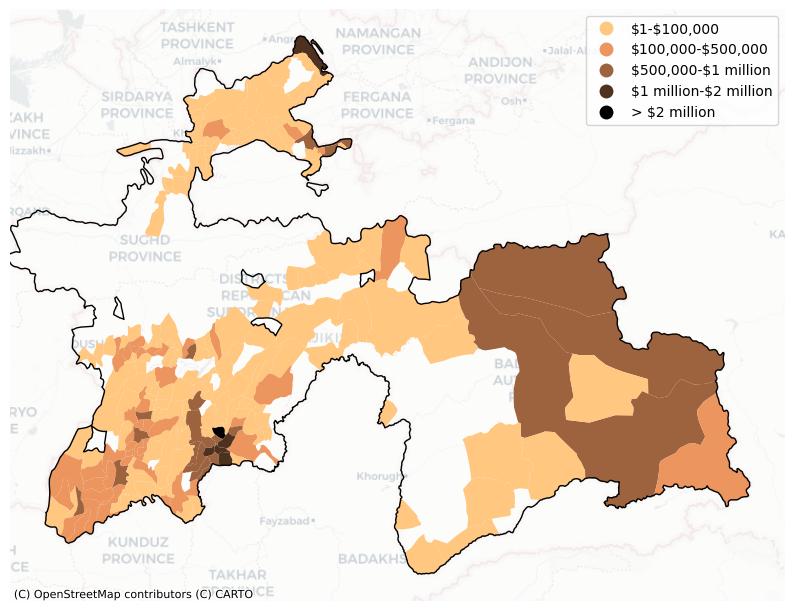

In [9]:
subnational_df['binned'] =  pd.cut(subnational_df.ead,[0,1e4,5e4,1e6,2e6,subnational_df.ead.max()],labels=['\\$1-$100,000','\\$100,000-$500,000',
                                                                                                       '\\$500,000-$1 million','\\$1 million-$2 million','> $2 million'])

fig, ax = plt.subplots(1,1,figsize=(10, 10))

subnational_df.plot(column = 'binned',cmap='copper_r',legend=True,ax=ax)

cx.add_basemap(ax, source=cx.providers.CartoDB.Positron,alpha=0.5)
subnational_df.dissolve('GID_0').plot(ax=ax,facecolor="none",edgecolor='black')
ax.set_axis_off()

plt.savefig(figures_path /'eq_EAD_municipal.png', bbox_inches='tight', dpi=300)

In [34]:
ead_df['damage/km'] = ead_df.ead/(ead_df.overlay_2475/1000)

In [35]:
ead_df['damage/km'].max()

72038.38046612879

In [41]:
ead_df[ead_df['damage/km_binned'] == '> $25,000']

,osm_id,asset,geometry,ead,overlay_250,overlay_475,overlay_975,overlay_1500,overlay_2475,GID_3,damage/km,damage/km_binned
8136,32621541,primary,"LINESTRING (7753251.818 4551520.106, 7753289.7...",8488.205858,122.901679,122.901679,122.901679,122.901679,122.901679,TJK.3.23.5_1,69065.011129,"> $25,000"
8137,32623114,primary,"LINESTRING (7753251.818 4551520.106, 7753176.9...",579871.771788,8329.738469,8329.738469,8329.738469,9918.511542,9918.511542,TJK.3.23.4_1,58463.587940,"> $25,000"
8438,350579649,primary,"LINESTRING (7753330.031 4551425.304, 7753332.4...",48231.893408,699.993905,699.993905,699.993905,699.993905,699.993905,TJK.3.23.5_1,68903.304847,"> $25,000"
8581,495465074,primary,"LINESTRING (7736373.045 4543194.954, 7736458.7...",298833.632245,4288.854251,4288.854251,4288.854251,4677.123658,4677.123658,TJK.3.23.7_1,63892.608811,"> $25,000"
8643,588104227,primary,"LINESTRING (7735852.270 4537062.628, 7735914.9...",275041.932093,4005.516568,4005.516568,4005.516568,4586.304774,4586.304774,TJK.3.11.3_1,59970.269237,"> $25,000"
8644,588104228,primary,"LINESTRING (7735843.832 4537002.398, 7735852.2...",4134.313029,60.818228,60.818228,60.818228,60.818228,60.818228,TJK.3.11.3_1,67978.189004,"> $25,000"
8648,588578886,primary,"LINESTRING (7717905.364 4586932.183, 7717996.1...",6575.512564,91.277907,91.277907,91.277907,91.277907,91.277907,TJK.3.3.3_1,72038.380466,"> $25,000"
8746,743297455,primary,"LINESTRING (7735568.762 4534956.233, 7735569.9...",118490.078595,1746.206320,1746.206320,1746.206320,2064.674503,2064.674503,TJK.3.11.3_1,57389.229347,"> $25,000"
9185,32621572,secondary,"LINESTRING (7753983.143 4551269.471, 7753982.2...",203884.256967,3604.134260,3604.134260,3604.134260,4895.894309,4895.894309,TJK.3.23.5_1,41643.925316,"> $25,000"
9666,349486962,secondary,"LINESTRING (7738174.217 4539250.546, 7738496.5...",658207.752744,11888.239962,11888.239962,11888.239962,15273.052825,15273.052825,TJK.3.11.2_1,43096.017559,"> $25,000"


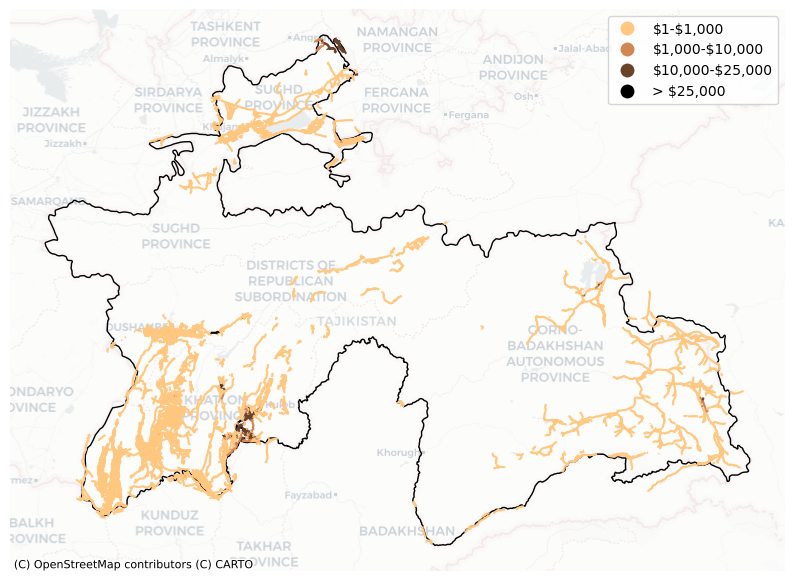

In [38]:
# figure EAD damages per km per road segment
ead_df['damage/km_binned'] = pd.cut(ead_df['damage/km'],[0,1e3,1e4,2.5e4,ead_df['damage/km'].max()],labels=['\\$1-$1,000','\\$1,000-$10,000','\\$10,000-$25,000','> $25,000'])
ead_df = gpd.GeoDataFrame(ead_df, geometry='geometry') # Set the GeoDataFrame's geometry column
ead_df = ead_df.to_crs(3857)

fig, ax = plt.subplots(1,1,figsize=(10, 10))
subnational.dissolve('GID_0').plot(ax=ax,facecolor="none",edgecolor='black')

ead_df.plot(column ='damage/km_binned',cmap='copper_r',legend=True,ax=ax)

cx.add_basemap(ax, source=cx.providers.CartoDB.Positron,alpha=0.5)
ax.set_axis_off()

plt.savefig(figures_path /'eq_EAD_km.png', bbox_inches='tight', dpi=300)